In [1]:
# load autoreload extension
%load_ext autoreload
%autoreload 2

In [2]:
import os
# os.environ['JAX_PLATFORMS']="cpu"
os.environ['JAX_PLATFORMS']="cuda"

In [ ]:
overwrite_model=False
restore_model=True
train_model=False

In [4]:
import orbax.checkpoint as ocp
checkpoint_dir = "/lhome/ific/a/aamerio/github/cfm-jax/checkpoints/two_moons_simformer_test2"

os.makedirs(checkpoint_dir, exist_ok=True)

if overwrite_model:
    checkpoint_dir = ocp.test_utils.erase_and_create_empty(checkpoint_dir)

In [5]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import optax

from corner import corner

import numpy as np

from tqdm.auto import tqdm

from functools import partial

from flax import nnx

/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import sys 
sys.path.append("examples/sbi-benchmarks")
sys.path.append("src/")
sys.path.append("/lhome/ific/a/aamerio/github/cfm-jax/src")

In [7]:
import sbibm
from utils.sbi_tasks import TwoMoons

from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import ODESolver

In [8]:
twomoons = TwoMoons()
task = twomoons.task
prior = twomoons.get_prior()
simulator = twomoons.get_simulator()
observation = twomoons.get_observation(1)

theta = prior.sample((10_000,))
xs = simulator(theta)

In [9]:
@partial(jax.jit, static_argnames=["size"])
def sample_prior(size):
    return jnp.array(prior.sample((size,)))

In [10]:
xs[:,0].max()

tensor(0.3623)

In [11]:
from numpyro import distributions as dist

In [12]:
prior_bound = 1.0
prior_params = {
    "low": -prior_bound * jnp.ones((2,)),
    "high": +prior_bound * jnp.ones((2,)),
}
prior_dist = dist.Uniform(**prior_params).to_event(1)

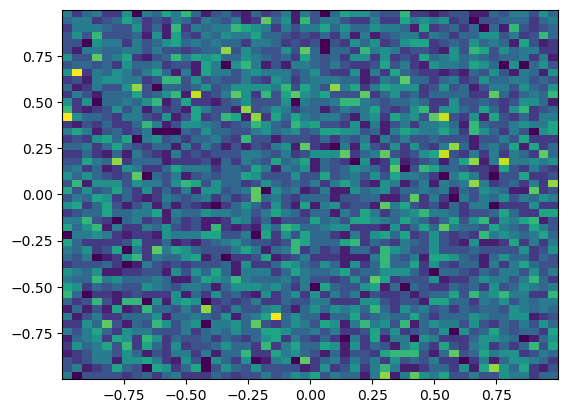

In [13]:
plt.hist2d(theta[:,0],theta[:,1], bins=50, density=True)
plt.show()

In [14]:
from sbibm.algorithms import rej_abc  # See help(rej_abc) for keywords
posterior_samples, _, _ = rej_abc(task=task, num_samples=10_000, num_observation=1, num_simulations=100_000)


Running REJ-ABC
INFO:sbibm.algorithms.sbi.mcabc:Running REJ-ABC
Running 100000 simulations.: 100%|██████████| 100000/100000 [00:00<00:00, 2600199.62it/s]
/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 864, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/sklearn/base.py", line 1382,

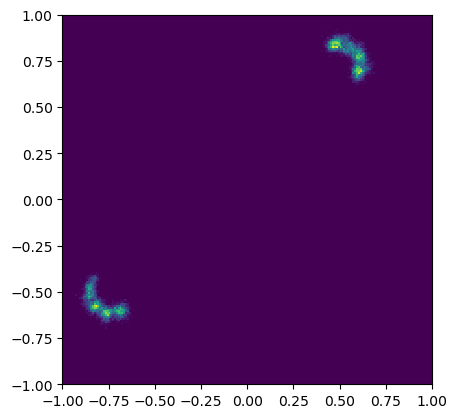

In [15]:
plt.hist2d(posterior_samples[:, 0], posterior_samples[:, 1], bins=(200,200), range=[(-1, 1), (-1, 1)], density=True)
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [16]:
# Once we got samples from an approximate posterior, compare them to the reference:
from sbibm.metrics import c2st
reference_samples = task.get_reference_posterior_samples(num_observation=1)

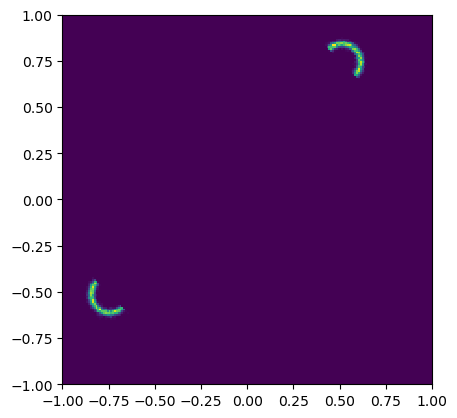

In [17]:
plt.hist2d(reference_samples[:, 0], reference_samples[:, 1], bins=(200,200), range=[(-1, 1), (-1, 1)], density=True)
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [18]:
# c2st_accuracy = c2st(reference_samples, posterior_samples)

In [19]:
# c2st_accuracy # around 0.6

# dataset

In [20]:
# make a dataset
nsamples = int(1e6)
theta = prior.sample((nsamples,))
xs = jnp.array(simulator(theta))
node_ids = jnp.array(twomoons.get_node_id())
dim_theta = twomoons.get_theta_dim()
dim_x = twomoons.get_x_dim()

# turn them into jax arrays
theta = jnp.array(theta)
xs = jnp.array(xs)

# concatenate the data, theta and xs
data = jnp.concatenate((theta, xs), axis=-1)

val_perc = 0.05

train_size = int(nsamples * (1 - val_perc)) 

train_data = data[:train_size]
val_data = data[train_size:]


In [21]:
# make an infinite dataloader that shuffles the data once it finishes cycling it
class InfiniteDataLoader:
    def __init__(self, data, batch_size, *, rng):
        self.data = data
        self.batch_size = batch_size
        self.index = 0
        self.rng = rng

        self.data_mean = jnp.mean(data, axis=0)
        self.data_std = jnp.std(data, axis=0)

        # self.data = self.normalize(self.data)

    def normalize(self, unnormalized_data):
        # Normalize the data to be between 0 mean and unit varainve
        data = unnormalized_data - self.data_mean
        data = data / self.data_std

        return data

    def unnormalize(self, normdata):
        # Unnormalize the data
        data = normdata * self.data_std
        data = data + self.data_mean
        return data

    def __iter__(self):
        return self

    def __next__(self):
        if self.index >= len(self.data) or self.index + self.batch_size >= len(self.data):
            self._shuffle()
        batch = self.data[self.index : self.index + self.batch_size]
        self.index += self.batch_size
        return batch

    def __len__(self):
        return len(self.data) // self.batch_size

    def __getitem__(self, index):
        return self.data[index]

    def _shuffle(self):
        key, self.rng = jax.random.split(self.rng)
        self.data = jax.random.permutation(key, self.data)
        self.index = 0

In [22]:
batch_size = 1024
dataset = InfiniteDataLoader(train_data, batch_size, rng=nnx.Rngs(0).dataset())

# define the CFM model

In [68]:
path = AffineProbPath(scheduler=CondOTScheduler()) # define the probability path

In [69]:
from models import Simformer, SimformerParams, SimformerCFMLoss, SimformerConditioner

In [70]:
dim_joint= len(twomoons.get_node_id())

In [71]:
params = SimformerParams(
    rngs = nnx.Rngs(0),
    dim_value = 40,
    dim_id = 40, 
    dim_condition = 10, 
    dim_joint= dim_joint,
    fourier_features = 128,
    num_heads = 4,
    num_layers = 6,
    widening_factor = 3,
    qkv_features = 12,
    num_hidden_layers = 1,
    dropout_rate = 0.0)

In [72]:
loss_fn_cfm = SimformerCFMLoss(path)

In [73]:
def marginalize(rng: jax.random.PRNGKey, edge_mask: jax.Array):
    # Simple function that marginializes out a single node from a adjacency matrix of a graph.
    idx = jax.random.choice(rng, jnp.arange(edge_mask.shape[0]), shape=(1,), replace=False)
    edge_mask = edge_mask.at[idx, :].set(False)
    edge_mask = edge_mask.at[:, idx].set(False)
    edge_mask = edge_mask.at[idx, idx].set(True)
    return edge_mask

In [74]:
undirected_edge_mask = twomoons.get_edge_mask_fn("undirected")(node_ids, None)
posterior_faithfull = twomoons.get_edge_mask_fn("faithfull")(node_ids, condition_mask=jnp.array([0,0,1,1]))

In [75]:
@partial(jax.jit, static_argnames=["nsamples"])
def get_random_condition_mask(rng: jax.random.PRNGKey, nsamples):
    mask_joint = jnp.zeros((5*nsamples, dim_joint ), dtype=jnp.bool_)
    mask_posterior = jnp.concatenate([jnp.zeros((nsamples, dim_theta), dtype=jnp.bool_), jnp.ones((nsamples, dim_x), dtype=jnp.bool_)], axis=-1)
    # mask_likelihood = jnp.concatenate([jnp.ones((nsamples, dim_theta), dtype=jnp.bool_), jnp.zeros((nsamples, dim_x), dtype=jnp.bool_)], axis=-1)
    
    mask1 = jax.random.bernoulli(rng, p=0.3, shape=(nsamples, dim_joint))
    filter = ~jnp.all(mask1, axis=-1)
    mask1 = jnp.logical_and(mask1, filter.reshape(-1,1))

    # masks = jnp.concatenate([mask_joint, mask1, mask_posterior, mask_likelihood], axis=0)
    masks = jnp.concatenate([mask_joint, mask1, mask_posterior], axis=0)
    return  jax.random.choice(rng, masks, shape=(nsamples,), replace=False, axis=0)

# @partial(jax.jit, static_argnames=["nsamples"])
# def get_random_condition_mask(rng: jax.random.PRNGKey, nsamples):
#     mask_joint = jnp.zeros((nsamples, dim_joint ), dtype=jnp.bool_)
#     mask_posterior = jnp.concatenate([jnp.zeros((nsamples, dim_theta), dtype=jnp.bool_), jnp.ones((nsamples, dim_x), dtype=jnp.bool_)], axis=-1)
    
#     masks = jnp.concatenate([mask_joint, mask_posterior], axis=0)
#     return  jax.random.choice(rng, masks, shape=(nsamples,), replace=False, axis=0)
    

In [76]:
from numpyro import distributions as dist

p0_dist_model = dist.Independent(
    dist.Normal(loc=jnp.zeros((4,)), scale=jnp.ones((4,))),
    reinterpreted_batch_ndims=1
)

In [77]:
def loss_fn_(vf_model, key: jax.random.PRNGKey):

    batch_size = dataset.batch_size

    rng_x0, rng_t, rng_condition, rng_edge_mask1, rng_edge_mask2 = jax.random.split(key, 5)
    
    # Generate data and random times
    x_1 = next(dataset) # n, T_max, 1
    x_0 = p0_dist_model.sample(rng_x0, (batch_size,)) # n, T_max, 1
    # x_0 = jax.random.normal(rng_x0, x_1.shape) 
    
    t = jax.random.uniform(rng_t, x_1.shape[0])

    batch = (x_0, x_1, t)
    
    # Condition mask -> randomly condition on some data. Here you can choose between the different condition masks, and you should specify the conditionals you may want to compute afterwards.
    condition_mask = get_random_condition_mask(rng_condition, batch_size)

    # undirected_edge_mask 
    undirected_edge_mask_ = jnp.repeat(undirected_edge_mask[None,...], 3*batch_size, axis=0) # Dense default mask
    
    # faithfull posterior mask
    faithfull_edge_mask_ = jnp.repeat(posterior_faithfull[None,...], 3*batch_size, axis=0) # Dense default mask
    
    # Include marginal consistency
    marginal_mask = jax.vmap(marginalize, in_axes=(0,None))(jax.random.split(rng_edge_mask1, (batch_size,)), undirected_edge_mask)
    edge_masks = jnp.concatenate([undirected_edge_mask_, faithfull_edge_mask_, marginal_mask], axis=0)
    edge_masks = jax.random.choice(rng_edge_mask2, edge_masks, shape=(batch_size,), axis=0) # Randomly choose between dense and marginal mask


    # Forward diffusion, do not perturb conditioned data
    # Will use the condition mask to mask to prevent adding noise for nodes that are conditioned.
    loss = loss_fn_cfm(vf_model, batch, node_ids=node_ids, edge_mask=edge_masks,condition_mask=condition_mask, )

    return loss

In [78]:
def val_loss(vf_model, key):
    batch_size = val_data.shape[0]

    rng_x0, rng_t, rng_condition, rng_edge_mask1, rng_edge_mask2 = jax.random.split(key, 5)
    
    # Generate data and random times
    x_1 = val_data
    x_0 = p0_dist_model.sample(rng_x0, (batch_size,)) # n, T_max, 1
    
    t = jax.random.uniform(rng_t, x_1.shape[0])

    batch = (x_0, x_1, t)
    
    # Condition mask -> randomly condition on some data. Here you can choose between the different condition masks, and you should specify the conditionals you may want to compute afterwards.
    condition_mask = get_random_condition_mask(rng_condition, batch_size)

    # undirected_edge_mask 
    undirected_edge_mask_ = jnp.repeat(undirected_edge_mask[None,...], 3*batch_size, axis=0) # Dense default mask
    
    # faithfull posterior mask
    faithfull_edge_mask_ = jnp.repeat(posterior_faithfull[None,...], 3*batch_size, axis=0) # Dense default mask
    
    # Include marginal consistency
    marginal_mask = jax.vmap(marginalize, in_axes=(0,None))(jax.random.split(rng_edge_mask1, (batch_size,)), undirected_edge_mask)
    edge_masks = jnp.concatenate([undirected_edge_mask_, faithfull_edge_mask_, marginal_mask], axis=0)
    edge_masks = jax.random.choice(rng_edge_mask2, edge_masks, shape=(batch_size,), axis=0) # Randomly choose between dense and marginal mask


    # Forward diffusion, do not perturb conditioned data
    # Will use the condition mask to mask to prevent adding noise for nodes that are conditioned.
    loss = loss_fn_cfm(vf_model, batch, node_ids=node_ids, edge_mask=edge_masks,condition_mask=condition_mask, )

    return loss

In [79]:
@nnx.jit
def train_step(model, optimizer, rng):
    loss_fn = lambda model: loss_fn_(model, rng)
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)  # In place updates.
    return loss

In [80]:
vf_model = Simformer(params)

In [81]:
# restore the model
if restore_model:
    model_state = nnx.state(vf_model)
    graphdef, abstract_state = nnx.split(vf_model)

    with ocp.CheckpointManager(
        checkpoint_dir, options=ocp.CheckpointManagerOptions(read_only=True)
    ) as read_mgr:
        restored = read_mgr.restore(
            1,
            # pass in the model_state to restore the exact same State type
            args=ocp.args.Composite(state=ocp.args.PyTreeRestore(item=model_state))
        )

    vf_model= nnx.merge(graphdef, restored["state"])
    print("Restored model from checkpoint")

In [82]:
nsteps = 10_000 
nepochs = 5


schedule = optax.schedules.linear_schedule(1e-3, 1e-6, 45000, 5000)

opt = optax.chain(optax.adaptive_grad_clip(10.0), optax.adamw(schedule))

# opt = optax.MultiSteps(opt, 2)

optimizer = nnx.Optimizer(vf_model, opt)

In [83]:
rngs = nnx.Rngs(0)

In [ ]:
best_state = nnx.state(vf_model)
val_loss_value = val_loss(vf_model, jax.random.PRNGKey(0))
val_error_ratio = 1.1
counter = 0
cmax = 10
print_every = 100
early_stopping = True
# early_stopping = False


# optimizer = nnx.Optimizer(vf_model, optax.adam(1e-4)) 

if train_model:
    vf_model.train()

    for ep in range(nepochs):
        pbar = tqdm(range(nsteps))
        l = 0
        for j in pbar:
            if counter > cmax and early_stopping:
                print("Early stopping")
                # restore the model state
                graphdef, abstract_state = nnx.split(vf_model)

                vf_model = nnx.merge(graphdef, best_state)
                break
            
            key_ = rngs.train_step()
            loss = train_step(vf_model, optimizer, key_)
            l += loss.item()
            if j>0 and j % 100 == 0:
                loss_ = l/100
                val_ = val_loss(vf_model, rngs.val_step())

                ratio = val_ / loss_
                
                if ratio < val_error_ratio:
                    val_loss_value = val_
                    counter = 0
                    best_state = nnx.state(vf_model)
                else:
                    counter += 1
                pbar.set_postfix(loss=f"{l/(100):.4f}", ratio=f"{ratio:.4f}", counter=counter)
                l=0
        # print(l)



    vf_model.eval()

 78%|███████▊  | 7783/10000 [02:33<00:31, 70.64it/s, counter=0, loss=0.5274, ratio=1.0093]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x2b95b60c3320>>
Traceback (most recent call last):
  File "/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
 85%|████████▍ | 8453/10000 [02:45<00:21, 72.12it/s, counter=0, loss=0.5238, ratio=1.0093]

 85%|████████▍ | 8497/10000 [02:46<00:29, 51.01it/s, counter=0, loss=0.5238, ratio=1.0093]


KeyboardInterrupt: 

In [ ]:
# save the model
if train_model:
    checkpoint_manager = ocp.CheckpointManager(checkpoint_dir,
        options=ocp.CheckpointManagerOptions(
            max_to_keep=2,
            keep_checkpoints_without_metrics=True,
            create=True,
        ),
    )
    model_state = nnx.state(vf_model)
    checkpoint_manager.save(
        1, args=ocp.args.Composite(state=ocp.args.PyTreeSave(model_state))
    )

    checkpoint_manager.close()

# sample the posterior

In [ ]:
from flow_matching.utils import ModelWrapper
class SimWrapper(ModelWrapper):
    def __init__(self, model):
        super().__init__(model)

    def __call__(self, x, t, args, **kwargs):
        return self.model(obs=x, timesteps=t, **kwargs)

In [ ]:
vf_cond = SimformerConditioner(vf_model)
vf_wrapped = SimWrapper(vf_cond)

In [ ]:
# we want to do conditional inference. We need an observation for which we want to ocmpute the posterior
idx=8
observation = jnp.array(twomoons.get_observation(idx))
reference_samples = task.get_reference_posterior_samples(num_observation=idx)

In [ ]:
rng = jax.random.PRNGKey(45)
T = jnp.linspace(0,1,10)  # sample times
step_size = 0.001

nsamples = 10_000 #reference_samples.shape[0]

key1,key2 = jax.random.split(rng, 2)

x_init = jax.random.normal(key1,(nsamples, dim_x)) # n, T_max, 1
cond = jnp.broadcast_to(observation[...,None], (nsamples, dim_theta, 1)) # n, dim_theta, 1

obs_ids = jnp.array([0, 1])
cond_ids = jnp.array([2, 3])
model_extras = {"cond": cond, "obs_ids": obs_ids, "cond_ids": cond_ids, "edge_mask": posterior_faithfull}

In [ ]:
solver = ODESolver(velocity_model=vf_wrapped)  # create an ODESolver class

sampler_ = solver.get_sampler(time_grid=T, method='Dopri5', step_size=step_size, return_intermediates=False, model_extras=model_extras)
samples = sampler_(x_init)  # sample from the model


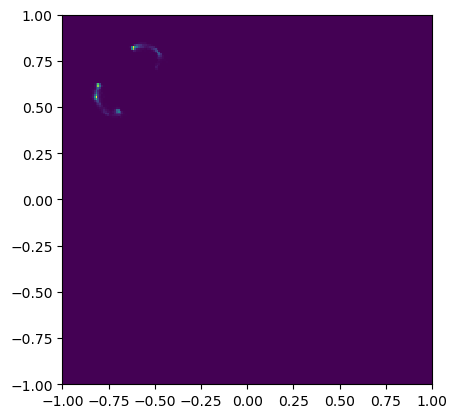

In [ ]:
posterior_samples = samples

plt.hist2d(posterior_samples[:,0], posterior_samples[:,1], bins=200, range=[(-1, 1), (-1, 1)], density=True)
# same ratio on axis 
# plt.scatter(reference_samples[:,0], reference_samples[:,1], s=0.1, color='red', alpha=0.1, marker='x')
plt.gca().set_aspect('equal', adjustable='box')
# plt.xlim((-1,1))
# plt.ylim((-1,1))
plt.show()

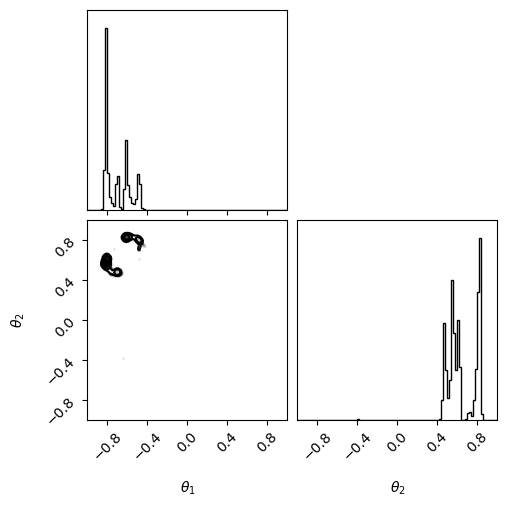

In [ ]:
corner(np.array(posterior_samples), bins=100, smooth=True, range=[(-1, 1), (-1, 1)], labels=['$\\theta_1$', '$\\theta_2$'])
plt.show()

/tmp/ipykernel_132014/1071246627.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  corner(np.array(reference_samples), bins=100, smooth=True, range=[(-1, 1), (-1, 1)], labels=['$\\theta_1$', '$\\theta_2$'])


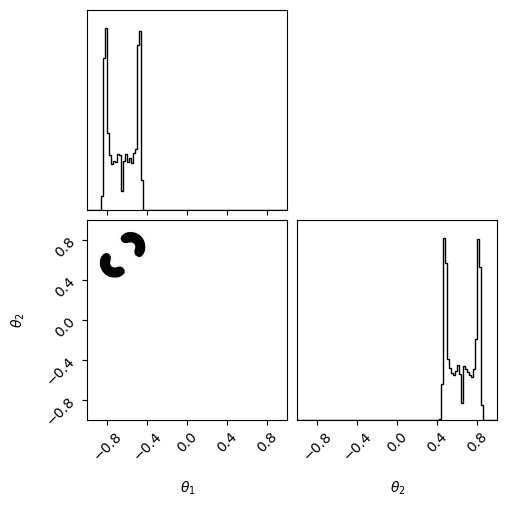

In [ ]:
corner(np.array(reference_samples), bins=100, smooth=True, range=[(-1, 1), (-1, 1)], labels=['$\\theta_1$', '$\\theta_2$'])
plt.show()

# evaluate the posterior

In [ ]:
p0_cond = dist.Independent(
    dist.Normal(loc=jnp.zeros((2,)), scale=jnp.ones((2,))),
    reinterpreted_batch_ndims=1
)

In [ ]:
grid_size = 200
x_1 = jnp.meshgrid(jnp.linspace(-1, 1, grid_size), jnp.linspace(-1, 1, grid_size))
x_1 = jnp.stack([x_1[0].flatten(), x_1[1].flatten()], axis=1)

# cond = jnp.broadcast_to(observation[...,None], (x_1.shape[0], dim_theta,1)) # n, dim_theta, 1
cond = jnp.broadcast_to(observation, (x_1.shape[0], dim_theta)) # n, dim_theta, 1

obs_ids = jnp.array([0, 1])
cond_ids = jnp.array([2, 3])
model_extras = {"cond": cond, "obs_ids": obs_ids, "cond_ids": cond_ids, "edge_mask": posterior_faithfull}

In [ ]:
# # get the logprob
# # logp_sampler = solver.get_unnormalized_logprob(condition_mask=condition_mask, time_grid=[1.0,0.0],method='Dopri5', step_size=step_size, log_p0=p0_dist_model.log_prob, model_extras=model_extras)
# logp_sampler = solver.get_unnormalized_logprob(time_grid=[1.0,0.0],method='Dopri5', step_size=step_size, log_p0=p0_cond.log_prob, model_extras=model_extras)
# # create an y_init which has theta on the first position and x1,x2 on the second and third position

# y_init = p0_cond.sample(jax.random.PRNGKey(0), (x_1.shape[0],))  # n, dim_theta

# _ , exact_log_p = logp_sampler(y_init)
# p = jnp.exp(exact_log_p)[-1]


In [ ]:
# p_grid = p.reshape((grid_size, grid_size))
# plt.imshow(p_grid, origin='lower', aspect='auto', extent=(-1, 1, -1, 1), cmap='viridis', vmin=0, vmax=10)
# # plt.scatter(posterior_samples[:100,0], posterior_samples[:100,1], alpha=1, color='red', s=2)
# plt.xlim((-1,1))
# plt.ylim((-1,1))
# plt.colorbar()
# plt.show()

# C2ST test

In [ ]:
# convert posterior samples to a torch array
import torch
# posterior_samples_cfg_torch = torch.tensor(np.array(posterior_samples_cfg))
posterior_samples_torch = torch.tensor(np.array(posterior_samples))

/tmp/ipykernel_132014/1936129747.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  corner(np.array(posterior_samples_torch), range=[(-1, 1), (-1, 1)], bins=100, smooth=True, labels=['$\\theta_1$', '$\\theta_2$'])


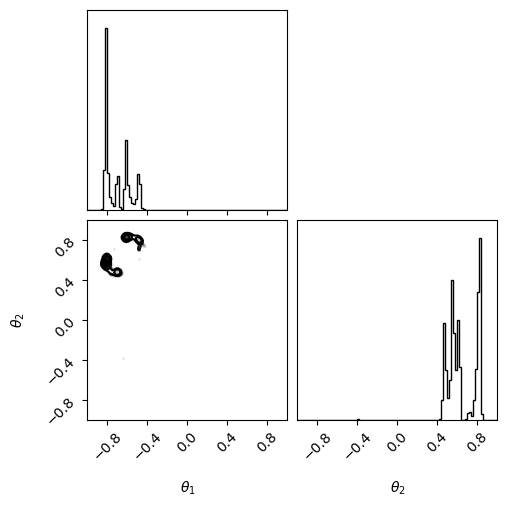

In [ ]:
corner(np.array(posterior_samples_torch), range=[(-1, 1), (-1, 1)], bins=100, smooth=True, labels=['$\\theta_1$', '$\\theta_2$'])
plt.show()

/tmp/ipykernel_132014/3478982405.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  corner(np.array(reference_samples), range=[(-1, 1), (-1, 1)], bins=100, smooth=True, labels=['$\\theta_1$', '$\\theta_2$'])


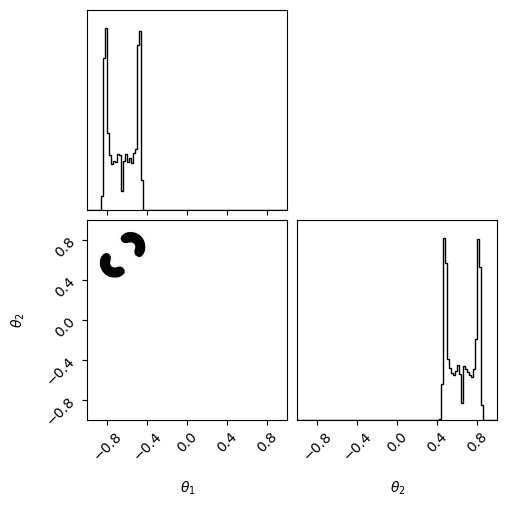

In [ ]:
corner(np.array(reference_samples), range=[(-1, 1), (-1, 1)], bins=100, smooth=True, labels=['$\\theta_1$', '$\\theta_2$'])
plt.show()

In [ ]:
# c2st_accuracy_cfg = c2st(reference_samples, posterior_samples_cfg_torch)
c2st_accuracy = c2st(reference_samples, posterior_samples_torch)

In [ ]:
c2st_accuracy

tensor([0.7696])